In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore", message=".*Try using .loc.*")
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


In [6]:
# data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Nov_27.parquet')
data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_6.parquet')

# Renombrar columnas
data.columns = [
    col + '_Tempe' if col.startswith('Promedio') or col.startswith('VALORES') else col
    for col in data.columns
]

data = data.rename(columns={'Precio promedio por kilogramo*_MIN': 'Precio_promedio_x_kilogramo_MIN', 
                            'Precio promedio por kilogramo*_MAX': 'Precio_promedio_x_kilogramo_MAX', 
                            'Precio promedio por kilogramo*_MEAN': 'Precio_promedio_x_kilogramo_MEDIA',
                            'Precio promedio por kilogramo*_STD': 'Precio_promedio_x_kilogramo_STD',
                            })
      
data.to_csv('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.csv')
data.to_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

In [2]:
data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

### Modelo Econometrico. 
#### Solo variables climatologicas.

In [3]:
# Importar librerías necesarias
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# Cargar dato
data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

In [5]:
# Filtrar los datos excluyendo el año 2013
filtered_data = data[data['Año'] != 2013]

# Dividir los datos en conjuntos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = filtered_data[(filtered_data['Año'] >= 2014) & (filtered_data['Año'] <= 2020)]
validation_data = filtered_data[filtered_data['Año'] >= 2021]

# Definir y ajustar el modelo
#formula = "Total_producci_n_t ~ Promedio_Dia_1_Tempe + Promedio_Dia_2_Tempe + Promedio_Dia_3_Tempe + Promedio_Noche_1_Tempe + Promedio_Noche_2_Tempe + Promedio_Noche_3_Tempe"
#model = smf.ols(formula=formula, data=train_data).fit()

In [26]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Leer datos
data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
filtered_data = data[data['Año'] != 2013]
# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = filtered_data[(filtered_data['Año'] >= 2014) & (filtered_data['Año'] <= 2020)]
test_data = filtered_data[filtered_data['Año'] >= 2021]

# Crear listas para almacenar las métricas y los coeficientes de cada iteración
iterations_metrics = []
coefficients_data = []

# Variables adicionales que se irán agregando en cada iteración
additional_variables = [
    "Total_rea_cosechada_ha",
    "Precio_promedio_x_kilogramo_MEDIA",
    "Total_rendimiento_t_ha"#,
    #"SUBREGION"
]

# Fórmula inicial
base_formula = (
    "Total_producci_n_t ~ Promedio_Dia_1_Tempe + Promedio_Dia_2_Tempe + Promedio_Dia_3_Tempe "
    "+ Promedio_Noche_1_Tempe + Promedio_Noche_2_Tempe + Promedio_Noche_3_Tempe + SUBREGION +"
    + " + ".join([f"Promedio_Dia_{dia}_M{mes}_Tempe" for dia in range(1, 4) for mes in range(1, 13)])
)

# Evaluar la fórmula base
model = smf.ols(formula=base_formula, data=train_data).fit()
test_data['predictions'] = model.predict(test_data)

# Filtrar valores donde Total_producci_n_t es 0 para evitar divisiones por cero en MAPE
test_data = test_data[test_data['Total_producci_n_t'] != 0]

# Calcular métricas para la fórmula base
mse = mean_squared_error(test_data['Total_producci_n_t'], test_data['predictions'])
mae = mean_absolute_error(test_data['Total_producci_n_t'], test_data['predictions'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data['Total_producci_n_t'] - test_data['predictions']) / test_data['Total_producci_n_t'])) * 100
r2 = r2_score(test_data['Total_producci_n_t'], test_data['predictions'])

# Guardar las métricas de la fórmula base
iterations_metrics.append({
    "Iteration": 0,
    "Added Variable": "Base Formula",
    "Mean Squared Error (MSE)": mse,
    "Mean Absolute Error (MAE)": mae,
    "Root Mean Squared Error (RMSE)": rmse,
    "Mean Absolute Percentage Error (MAPE)": mape,
    "R-squared (R2)": r2
})

# Guardar los coeficientes de la fórmula base
coefficients_data.append({
    "Iteration": 0,
    **model.params.to_dict()
})

# Iterar añadiendo cada nueva variable a la fórmula
current_formula = base_formula
for var in additional_variables:
    # Agregar la nueva variable a la fórmula
    current_formula += f" + {var}"
    
    # Entrenar el modelo
    model = smf.ols(formula=current_formula, data=train_data).fit()
    
    # Realizar predicciones en los datos de validación
    test_data['predictions'] = model.predict(test_data)
    
    # Filtrar valores donde Total_producci_n_t es 0 para evitar divisiones por cero en MAPE
    test_data_filtered = test_data[test_data['Total_producci_n_t'] != 0]
    
    # Calcular métricas de validación
    mse = mean_squared_error(test_data_filtered['Total_producci_n_t'], test_data_filtered['predictions'])
    mae = mean_absolute_error(test_data_filtered['Total_producci_n_t'], test_data_filtered['predictions'])
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_data_filtered['Total_producci_n_t'] - test_data_filtered['predictions']) / test_data_filtered['Total_producci_n_t'])) * 100
    r2 = r2_score(test_data_filtered['Total_producci_n_t'], test_data_filtered['predictions'])
    
    # Guardar las métricas y la fórmula utilizada en esta iteración
    iterations_metrics.append({
        "Iteration": len(iterations_metrics),
        "Added Variable": var,
        "Mean Squared Error (MSE)": mse,
        "Mean Absolute Error (MAE)": mae,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Percentage Error (MAPE)": mape,
        "R-squared (R2)": r2
    })
    
    # Guardar los coeficientes del modelo actual
    coefficients_data.append({
        "Iteration": len(coefficients_data),
        **model.params.to_dict()
    })

# Crear DataFrames con las métricas y los coeficientes
metrics_df = pd.DataFrame(iterations_metrics)
coefficients_df = pd.DataFrame(coefficients_data)

In [27]:
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:     Total_producci_n_t   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     239.5
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:37:13   Log-Likelihood:            -3.1497e+05
No. Observations:               20959   AIC:                         6.300e+05
Df Residuals:                   20912   BIC:                         6.304e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [28]:
metrics_df

,Iteration,Added Variable,Mean Squared Error (MSE),Mean Absolute Error (MAE),Root Mean Squared Error (RMSE),Mean Absolute Percentage Error (MAPE),R-squared (R2)
0,0,Base Formula,1.389953e+13,510901.505426,3.728208e+06,302409.852014,-10.340197
1,1,Total_rea_cosechada_ha,1.468470e+12,277128.331755,1.211805e+06,73084.298953,-0.198079
2,2,Precio_promedio_x_kilogramo_MEDIA,1.164346e+12,262709.040522,1.079049e+06,75285.758535,0.050046
3,3,Total_rendimiento_t_ha,8.768785e+11,232086.650019,9.364179e+05,35999.624002,0.284582


In [29]:
coefficients_df

,Iteration,Intercept,Promedio_Dia_1_Tempe,Promedio_Dia_2_Tempe,Promedio_Dia_3_Tempe,Promedio_Noche_1_Tempe,Promedio_Noche_2_Tempe,Promedio_Noche_3_Tempe,SUBREGION,Promedio_Dia_1_M1_Tempe,...,Promedio_Dia_3_M6_Tempe,Promedio_Dia_3_M7_Tempe,Promedio_Dia_3_M8_Tempe,Promedio_Dia_3_M9_Tempe,Promedio_Dia_3_M10_Tempe,Promedio_Dia_3_M11_Tempe,Promedio_Dia_3_M12_Tempe,Total_rea_cosechada_ha,Precio_promedio_x_kilogramo_MEDIA,Total_rendimiento_t_ha
0,0,156837.428715,1.852753e+08,-11779.261942,-14396.569651,-1.198555e+08,18693.822692,16182.085824,-22572.526105,1.758050e-07,...,337.861311,676.436380,-966.222345,-195.493733,271.827395,-109.667088,-966.182655,NaN,NaN,NaN
1,1,-18267.757522,4.246783e+07,-3769.636226,-6305.366554,-2.746665e+07,8572.536384,5862.990468,-8027.838906,4.910451e-03,...,-1270.099230,1209.906812,49.668814,-339.614307,-247.872263,603.653983,-1705.524470,9.233644,NaN,NaN
2,2,-12440.127012,3.118202e+07,-3777.972976,-6019.323808,-2.016568e+07,8754.418353,5438.246466,-8778.226603,-1.350324e-03,...,-2141.516705,1257.228470,81.744182,-421.162435,-244.753453,588.169512,-1699.259411,9.226528,-4.675419,NaN
3,3,-109612.975420,1.755087e+07,-6038.122853,-6038.737194,-1.134327e+07,12075.650253,5203.232211,-809.493257,-1.727997e-04,...,-2232.719491,972.051754,249.689166,-267.758850,-197.266336,401.816920,-1637.550304,9.177265,-4.211096,54.725295


## Modelo No Lineal - XGBoost

In [30]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Cargar los datos
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
filtered_data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = filtered_data[(filtered_data['Año'] >= 2014) & (filtered_data['Año'] <= 2020)]
test_data = filtered_data[filtered_data['Año'] >= 2021]

# Crear listas para almacenar las métricas y los coeficientes de importancia
iterations_metrics = []
feature_importances = []

# Variables base y adicionales
base_features = [
    "Promedio_Dia_1_Tempe", "Promedio_Dia_2_Tempe", "Promedio_Dia_3_Tempe",
    "Promedio_Noche_1_Tempe", "Promedio_Noche_2_Tempe", "Promedio_Noche_3_Tempe", "SUBREGION"
] + [f"Promedio_Dia_{dia}_M{mes}_Tempe" for dia in range(1, 4) for mes in range(1, 13)]

additional_features = [
    "Total_rea_cosechada_ha",
    "Precio_promedio_x_kilogramo_MEDIA",
    "Total_rendimiento_t_ha"#,
    #"SUBREGION"
]

# Inicializar características actuales
current_features = base_features.copy()

# Separar X e y
X_train = train_data[current_features]
y_train = train_data['Total_producci_n_t']
X_test = test_data[current_features]
y_test = test_data['Total_producci_n_t']

# Modelo inicial con características base
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Calcular métricas iniciales
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test.replace(0, np.nan))) * 100  # Evitar división por cero
r2 = r2_score(y_test, predictions)

# Guardar métricas iniciales
iterations_metrics.append({
    "Iteration": 0,
    "Added Variable": "Base Features",
    "Mean Squared Error (MSE)": mse,
    "Mean Absolute Error (MAE)": mae,
    "Root Mean Squared Error (RMSE)": rmse,
    "Mean Absolute Percentage Error (MAPE)": mape,
    "R-squared (R2)": r2
})

# Guardar importancia de características iniciales
feature_importances.append({
    "Iteration": 0,
    **dict(zip(current_features, model.feature_importances_))
})

# Iterar añadiendo variables adicionales
for var in additional_features:
    # Agregar la nueva variable a las características actuales
    current_features.append(var)
    
    # Actualizar conjuntos de entrenamiento y validación
    X_train = train_data[current_features]
    X_test = test_data[current_features]
    
    # Entrenar modelo
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - predictions) / y_test.replace(0, np.nan))) * 100  # Evitar división por cero
    r2 = r2_score(y_test, predictions)
    
    # Guardar métricas de esta iteración
    iterations_metrics.append({
        "Iteration": len(iterations_metrics),
        "Added Variable": var,
        "Mean Squared Error (MSE)": mse,
        "Mean Absolute Error (MAE)": mae,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Percentage Error (MAPE)": mape,
        "R-squared (R2)": r2
    })
    
    # Guardar importancia de características
    feature_importances.append({
        "Iteration": len(feature_importances),
        **dict(zip(current_features, model.feature_importances_))
    })

# Crear DataFrames con las métricas y las importancias de las características
metrics_df = pd.DataFrame(iterations_metrics)
importances_df = pd.DataFrame(feature_importances)




In [31]:
metrics_df

,Iteration,Added Variable,Mean Squared Error (MSE),Mean Absolute Error (MAE),Root Mean Squared Error (RMSE),Mean Absolute Percentage Error (MAPE),R-squared (R2)
0,0,Base Features,9.226661e+11,266054.562500,960555.06250,56315.942383,0.240239
1,1,Total_rea_cosechada_ha,2.117952e+11,115416.140625,460212.12500,2469.259453,0.825599
2,2,Precio_promedio_x_kilogramo_MEDIA,1.960997e+11,104653.406250,442831.46875,2077.841568,0.838523
3,3,Total_rendimiento_t_ha,4.626881e+10,44715.722656,215101.87500,426.983261,0.961900


In [24]:
importances_df

,Iteration,Promedio_Dia_1_Tempe,Promedio_Dia_2_Tempe,Promedio_Dia_3_Tempe,Promedio_Noche_1_Tempe,Promedio_Noche_2_Tempe,Promedio_Noche_3_Tempe,Promedio_Dia_1_M1_Tempe,Promedio_Dia_1_M2_Tempe,Promedio_Dia_1_M3_Tempe,...,Promedio_Dia_3_M7_Tempe,Promedio_Dia_3_M8_Tempe,Promedio_Dia_3_M9_Tempe,Promedio_Dia_3_M10_Tempe,Promedio_Dia_3_M11_Tempe,Promedio_Dia_3_M12_Tempe,Total_rea_cosechada_ha,Precio_promedio_x_kilogramo_MEDIA,Total_rendimiento_t_ha,SUBREGION
0,0,0.000000,0.042663,0.032171,0.000798,0.066838,0.031642,0.0,0.0,0.0,...,0.007820,0.013189,0.002730,0.006238,0.002015,0.010011,NaN,NaN,NaN,NaN
1,1,0.000000,0.025888,0.052210,0.000063,0.057818,0.043203,0.0,0.0,0.0,...,0.005737,0.013769,0.014932,0.005180,0.029356,0.007226,0.398597,NaN,NaN,NaN
2,2,0.000043,0.024408,0.058862,0.000000,0.060021,0.047489,0.0,0.0,0.0,...,0.006002,0.026791,0.014413,0.006511,0.032360,0.018269,0.321760,0.016853,NaN,NaN
3,3,0.000000,0.000410,0.000415,0.000000,0.001694,0.000938,0.0,0.0,0.0,...,0.000268,0.000107,0.001231,0.004288,0.000828,0.000000,0.490046,0.045475,0.442682,NaN
4,4,0.000000,0.000222,0.000692,0.000000,0.001822,0.000779,0.0,0.0,0.0,...,0.000008,0.000468,0.000928,0.008561,0.001646,0.001224,0.502044,0.040279,0.424052,0.004704


# Hiperparametros

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Cargar los datos
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
filtered_data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = filtered_data[(filtered_data['Año'] >= 2014) & (filtered_data['Año'] <= 2020)]
test_data = filtered_data[filtered_data['Año'] >= 2021]

# Variables base y adicionales
base_features = [
    "Promedio_Dia_1_Tempe", "Promedio_Dia_2_Tempe", "Promedio_Dia_3_Tempe",
    "Promedio_Noche_1_Tempe", "Promedio_Noche_2_Tempe", "Promedio_Noche_3_Tempe"
] + [f"Promedio_Dia_{dia}_M{mes}_Tempe" for dia in range(1, 4) for mes in range(1, 13)]

additional_features = [
    "Total_rea_cosechada_ha",
    "Precio_promedio_x_kilogramo_MEDIA",
    "Total_rendimiento_t_ha",
    "SUBREGION"
]

# Inicializar características actuales
current_features = base_features.copy()

# Separar X e y
X_train = train_data[current_features]
y_train = train_data['Total_producci_n_t']
X_test = test_data[current_features]
y_test = test_data['Total_producci_n_t']

# Definir el modelo inicial
model = XGBRegressor(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 10, 100]
}

# Configurar la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica a optimizar
    cv=3,  # Validación cruzada
    verbose=2,
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros
print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = random_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Evaluar el mejor modelo en los datos de prueba
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Imprimir las métricas del modelo optimizado
print("\nDesempeño del mejor modelo en datos de prueba:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Guardar métricas y los mejores hiperparámetros en un archivo CSV (opcional)
results = pd.DataFrame([{
    "MSE": mse,
    "MAE": mae,
    "R2": r2,
    **random_search.best_params_
}])


Iniciando búsqueda de hiperparámetros...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores hiperparámetros encontrados:
{'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}

Desempeño del mejor modelo en datos de prueba:
Mean Squared Error (MSE): 1174476554240.0
Mean Absolute Error (MAE): 290761.8125
R-squared (R2): 0.032887816429138184


## Grafica Coeficientes

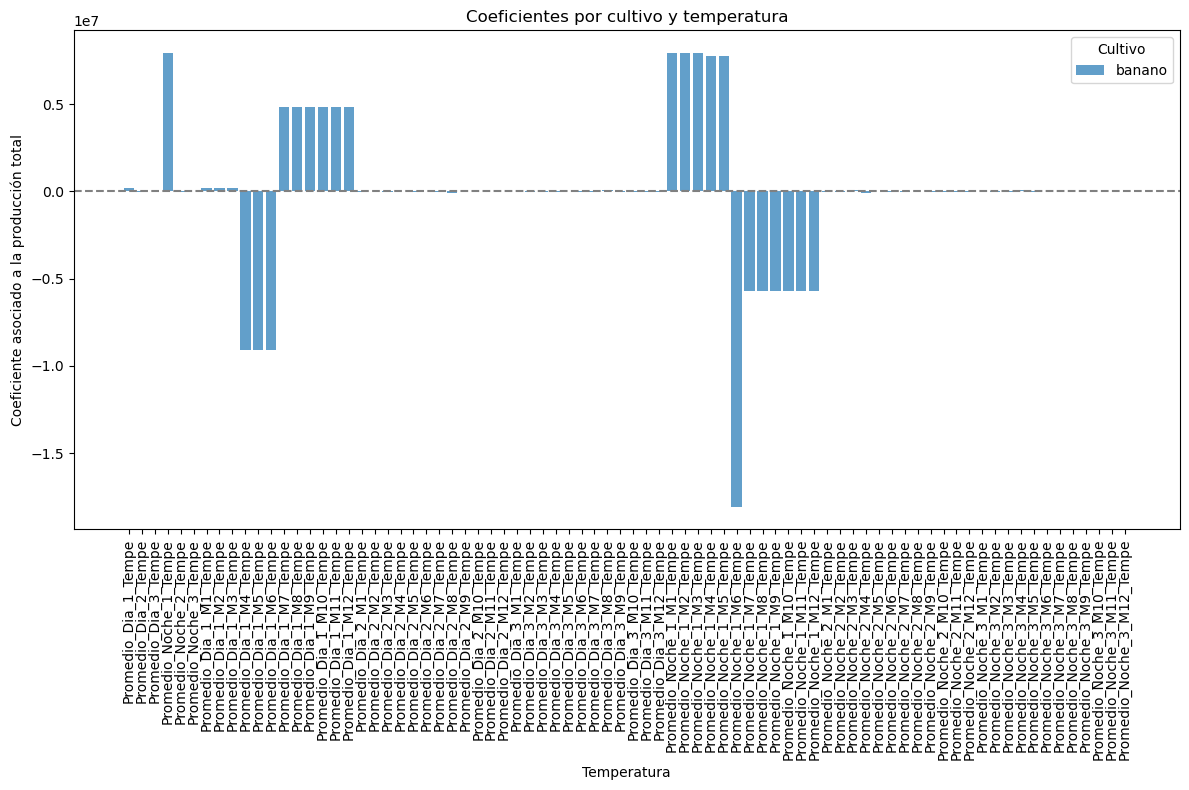

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]
# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['banano']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear la fórmula base para las temperaturas
temperature_columns = [
    col for col in filtered_data.columns if 'Tempe' in col and col.startswith('Promedio')
]
# base_formula = "Total_producci_n_t ~ " + " + ".join(temperature_columns)

base_formula = "Total_producci_n_t ~ Total_rea_cosechada_ha + Precio_promedio_x_kilogramo_MEDIA  + Total_rendimiento_t_ha +" + " + ".join(temperature_columns)

# Entrenar el modelo usando Ordinary Least Squares (OLS)
model = smf.ols(formula=base_formula, data=filtered_data).fit()

# Obtener los coeficientes asociados a las temperaturas
coefficients = model.params.filter(like='Tempe')

# Preparar los datos para graficar
coefficients_df = coefficients.reset_index()
coefficients_df.columns = ['Temperature', 'Coefficient']
coefficients_df['Crop'] = filtered_data['cultivo'].iloc[0]  # Asignar el cultivo como ejemplo

# Generar la gráfica de barras
plt.figure(figsize=(12, 8))
for crop in selected_crops:
    crop_data = coefficients_df[coefficients_df['Crop'] == crop]
    plt.bar(
        crop_data['Temperature'],
        crop_data['Coefficient'],
        label=crop,
        alpha=0.7
    )

# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--') 

# Configurar etiquetas y título
plt.xlabel('Temperatura')
plt.ylabel('Coeficiente asociado a la producción total')
plt.title('Coeficientes por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()

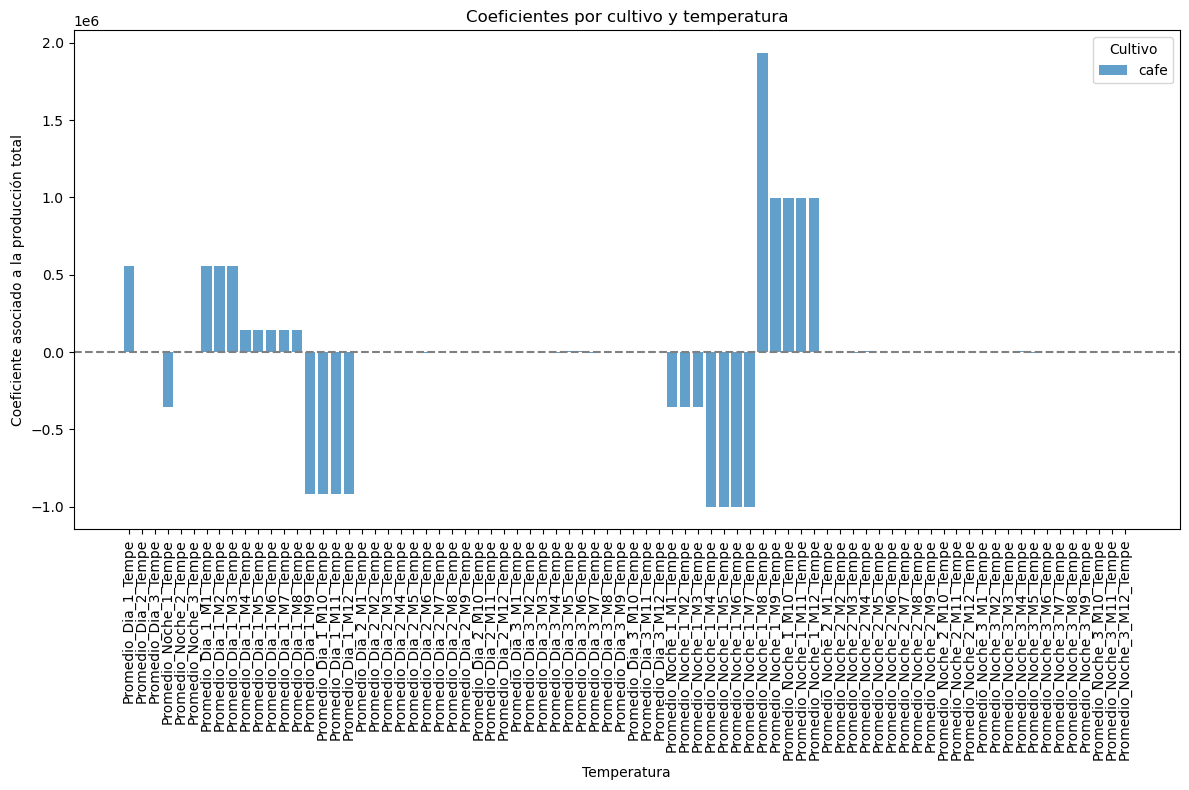

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]
# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['cafe']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear la fórmula base para las temperaturas
temperature_columns = [
    col for col in filtered_data.columns if 'Tempe' in col and col.startswith('Promedio')
]
# base_formula = "Total_producci_n_t ~ " + " + ".join(temperature_columns)

base_formula = "Total_producci_n_t ~ Total_rea_cosechada_ha + Precio_promedio_x_kilogramo_MEDIA  + Total_rendimiento_t_ha +" + " + ".join(temperature_columns)

# Entrenar el modelo usando Ordinary Least Squares (OLS)
model = smf.ols(formula=base_formula, data=filtered_data).fit()

# Obtener los coeficientes asociados a las temperaturas
coefficients = model.params.filter(like='Tempe')

# Preparar los datos para graficar
coefficients_df = coefficients.reset_index()
coefficients_df.columns = ['Temperature', 'Coefficient']
coefficients_df['Crop'] = filtered_data['cultivo'].iloc[0]  # Asignar el cultivo como ejemplo

# Generar la gráfica de barras
plt.figure(figsize=(12, 8))
for crop in selected_crops:
    crop_data = coefficients_df[coefficients_df['Crop'] == crop]
    plt.bar(
        crop_data['Temperature'],
        crop_data['Coefficient'],
        label=crop,
        alpha=0.7
    )

# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--') 

# Configurar etiquetas y título
plt.xlabel('Temperatura')
plt.ylabel('Coeficiente asociado a la producción total')
plt.title('Coeficientes por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()

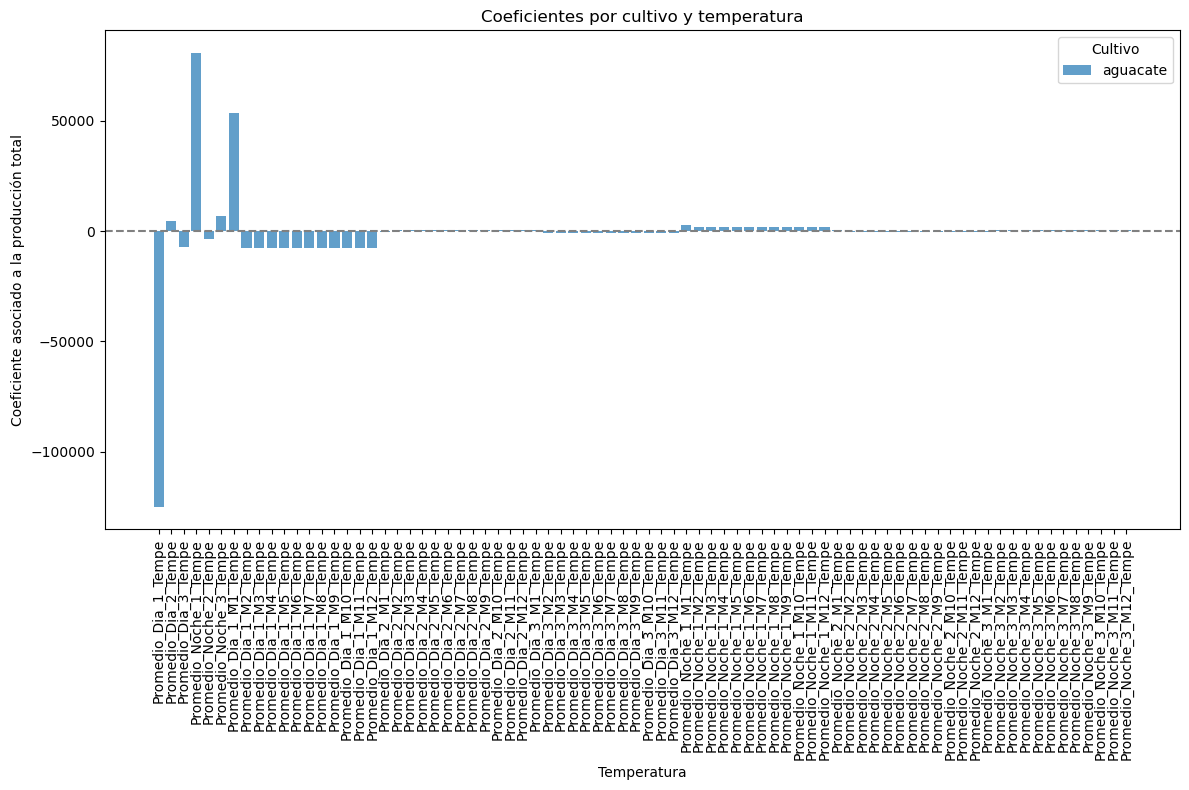

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]
# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['aguacate']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear la fórmula base para las temperaturas
temperature_columns = [
    col for col in filtered_data.columns if 'Tempe' in col and col.startswith('Promedio')
]
# base_formula = "Total_producci_n_t ~ " + " + ".join(temperature_columns)

base_formula = "Total_producci_n_t ~ Total_rea_cosechada_ha + Precio_promedio_x_kilogramo_MEDIA  + Total_rendimiento_t_ha +" + " + ".join(temperature_columns)

# Entrenar el modelo usando Ordinary Least Squares (OLS)
model = smf.ols(formula=base_formula, data=filtered_data).fit()

# Obtener los coeficientes asociados a las temperaturas
coefficients = model.params.filter(like='Tempe')

# Preparar los datos para graficar
coefficients_df = coefficients.reset_index()
coefficients_df.columns = ['Temperature', 'Coefficient']
coefficients_df['Crop'] = filtered_data['cultivo'].iloc[0]  # Asignar el cultivo como ejemplo

# Generar la gráfica de barras
plt.figure(figsize=(12, 8))
for crop in selected_crops:
    crop_data = coefficients_df[coefficients_df['Crop'] == crop]
    plt.bar(
        crop_data['Temperature'],
        crop_data['Coefficient'],
        label=crop,
        alpha=0.7
    )

# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--') 

# Configurar etiquetas y título
plt.xlabel('Temperatura')
plt.ylabel('Coeficiente asociado a la producción total')
plt.title('Coeficientes por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()

## Graficas Shap

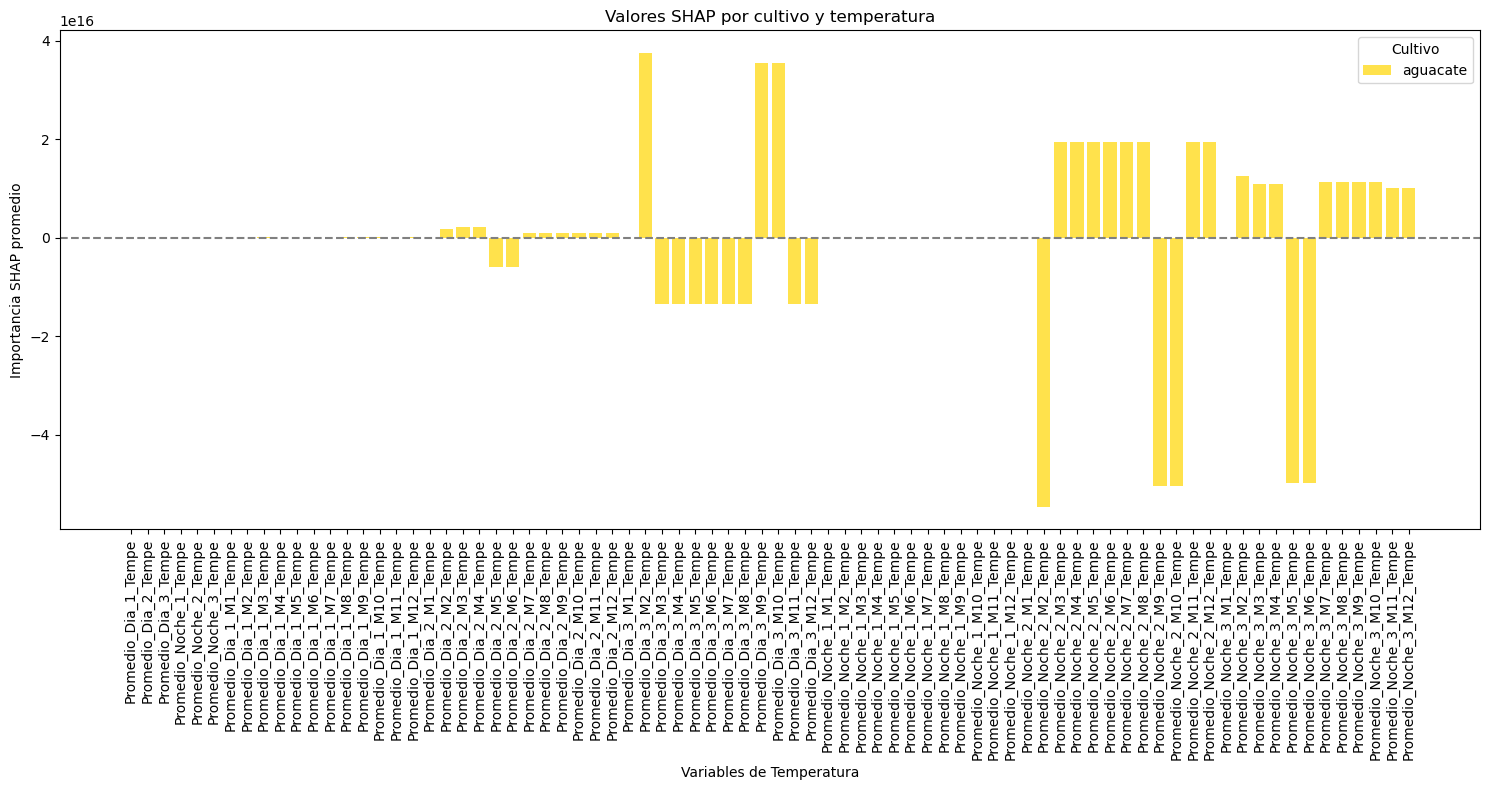

In [75]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV cargado
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]
# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]


# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['aguacate']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un contenedor para los valores SHAP por cultivo
all_shap_values = []
all_temperatures = []

for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]
    
    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo usando regresión lineal
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Calcular los valores SHAP
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    
    # Convertir los valores SHAP a DataFrame y agregar la columna Crop
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df['Crop'] = crop  # Agregar el cultivo actual
    all_shap_values.append(shap_df)
    all_temperatures.extend(X.columns)

# Concatenar todos los valores SHAP
shap_values_df = pd.concat(all_shap_values, ignore_index=True)

# Calcular la media de los valores SHAP para cada variable por cultivo
shap_summary = shap_values_df.groupby('Crop').mean().drop(columns=['Crop'], errors='ignore').T.reset_index()
shap_summary.columns = ['Temperature'] + selected_crops

# Generar la gráfica de barras
plt.figure(figsize=(15, 8))
for crop in selected_crops:
    crop_data = shap_summary[['Temperature', crop]]
    plt.bar(
        crop_data['Temperature'],
        crop_data[crop],
        label=crop,
        color="#FFD700",
        alpha=0.7
    )
# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--') 

# Configurar etiquetas y título
plt.xlabel('Variables de Temperatura')
plt.ylabel('Importancia SHAP promedio')
plt.title('Valores SHAP por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()

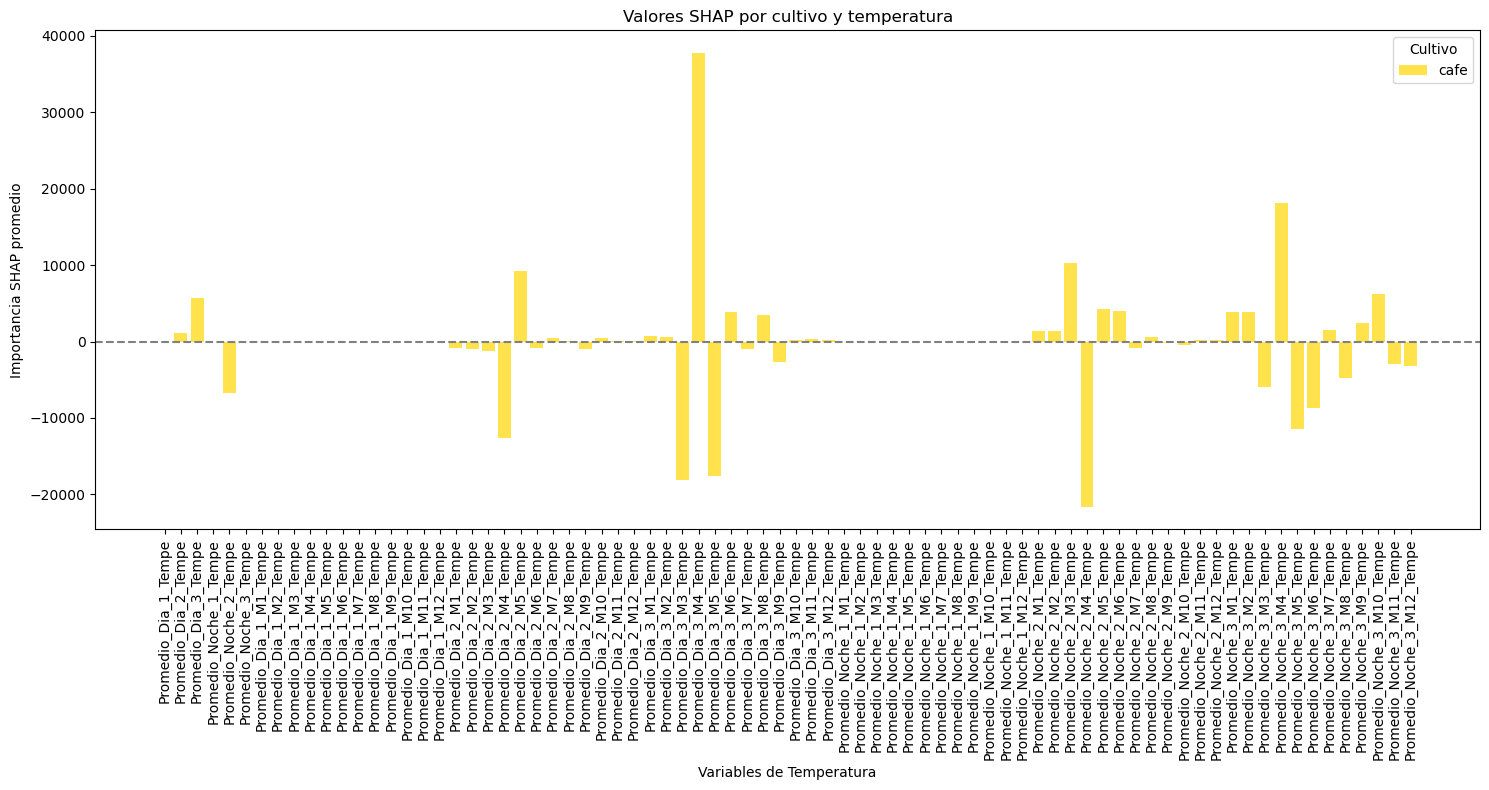

In [76]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV cargado
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]
# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['cafe']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un contenedor para los valores SHAP por cultivo
all_shap_values = []
all_temperatures = []

for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]
    
    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo usando regresión lineal
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Calcular los valores SHAP
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    
    # Convertir los valores SHAP a DataFrame y agregar la columna Crop
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df['Crop'] = crop  # Agregar el cultivo actual
    all_shap_values.append(shap_df)
    all_temperatures.extend(X.columns)

# Concatenar todos los valores SHAP
shap_values_df = pd.concat(all_shap_values, ignore_index=True)

# Calcular la media de los valores SHAP para cada variable por cultivo
shap_summary = shap_values_df.groupby('Crop').mean().drop(columns=['Crop'], errors='ignore').T.reset_index()
shap_summary.columns = ['Temperature'] + selected_crops

# Generar la gráfica de barras
plt.figure(figsize=(15, 8))
for crop in selected_crops:
    crop_data = shap_summary[['Temperature', crop]]
    plt.bar(
        crop_data['Temperature'],
        crop_data[crop],
        label=crop,
        color="#FFD700",
        alpha=0.7
    )

plt.axhline(0, color='gray', linewidth=1.5, linestyle='--') 

# Configurar etiquetas y título
plt.xlabel('Variables de Temperatura')
plt.ylabel('Importancia SHAP promedio')
plt.title('Valores SHAP por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()

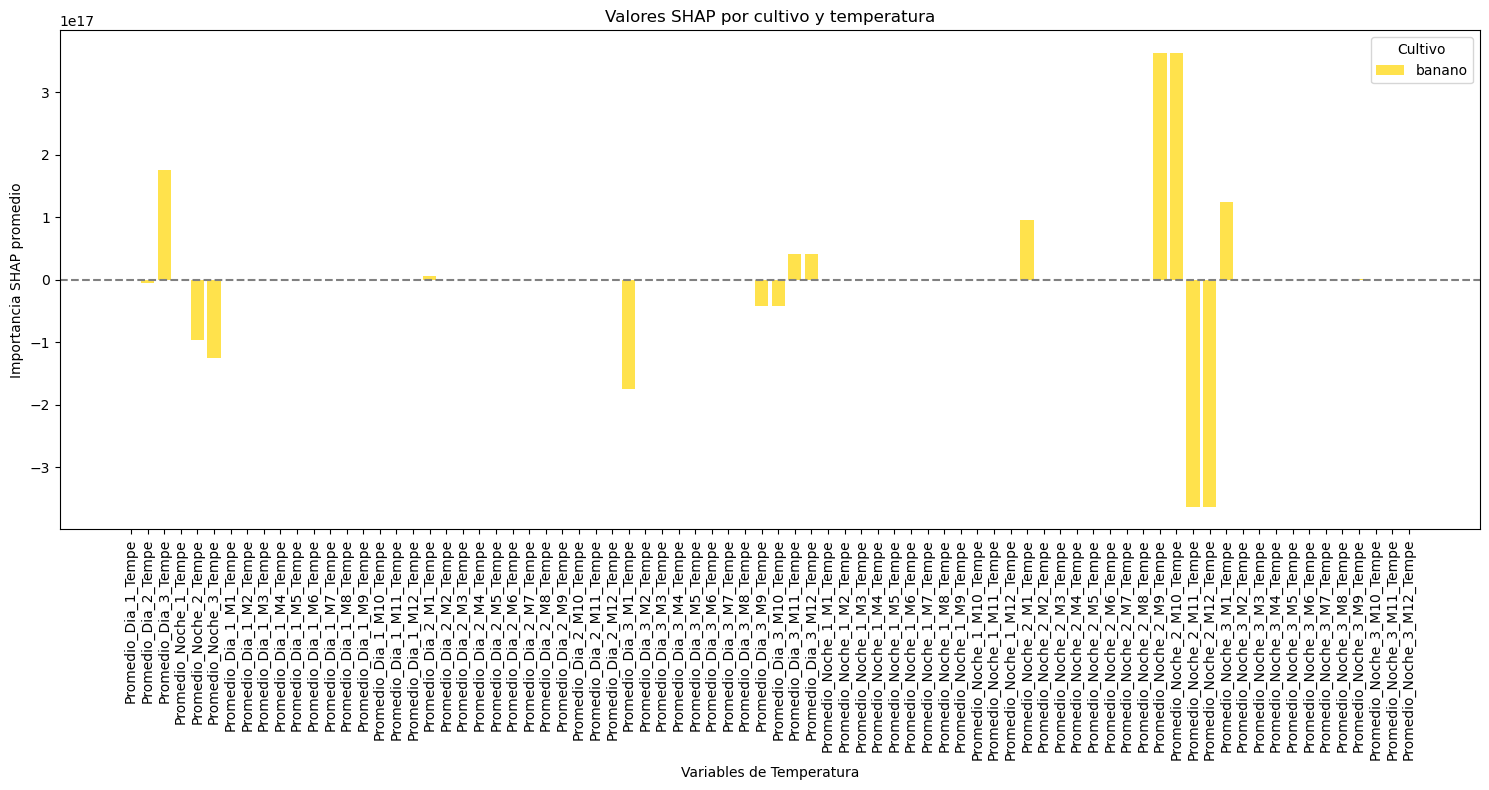

In [77]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV cargado
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]
# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]


# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['banano']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un contenedor para los valores SHAP por cultivo
all_shap_values = []
all_temperatures = []

for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]
    
    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo usando regresión lineal
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Calcular los valores SHAP
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    
    # Convertir los valores SHAP a DataFrame y agregar la columna Crop
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df['Crop'] = crop  # Agregar el cultivo actual
    all_shap_values.append(shap_df)
    all_temperatures.extend(X.columns)

# Concatenar todos los valores SHAP
shap_values_df = pd.concat(all_shap_values, ignore_index=True)

# Calcular la media de los valores SHAP para cada variable por cultivo
shap_summary = shap_values_df.groupby('Crop').mean().drop(columns=['Crop'], errors='ignore').T.reset_index()
shap_summary.columns = ['Temperature'] + selected_crops

# Generar la gráfica de barras
plt.figure(figsize=(15, 8))
for crop in selected_crops:
    crop_data = shap_summary[['Temperature', crop]]
    plt.bar(
        crop_data['Temperature'],
        crop_data[crop],
        label=crop,
        color="#FFD700",
        alpha=0.7
    )

plt.axhline(0, color='gray', linewidth=1.5, linestyle='--')  

# Configurar etiquetas y título
plt.xlabel('Variables de Temperatura')
plt.ylabel('Importancia SHAP promedio')
plt.title('Valores SHAP por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()


## XGBoost con valores SHAP

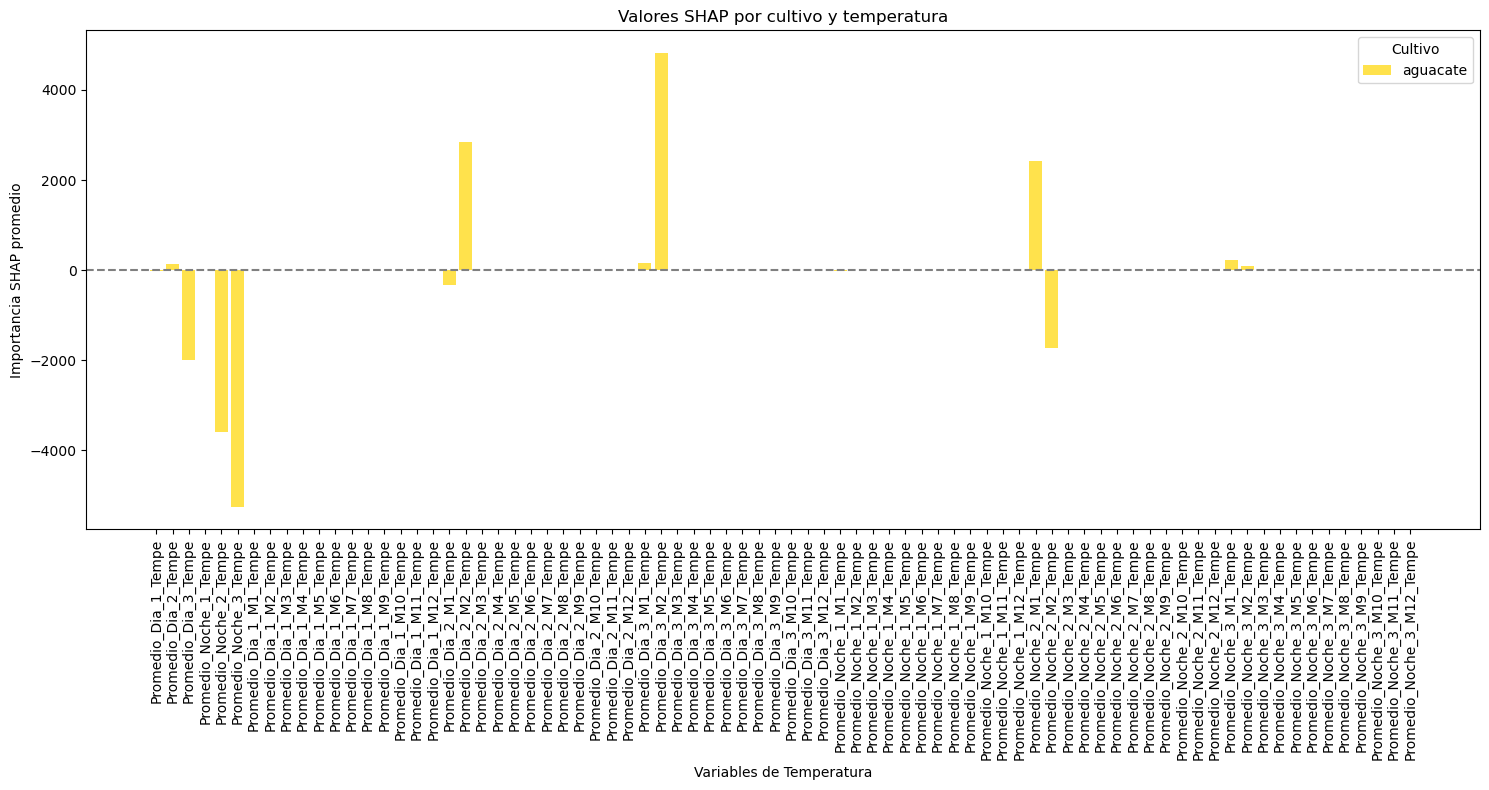

In [32]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV cargado
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['aguacate']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un contenedor para los valores SHAP por cultivo
all_shap_values = []
all_temperatures = []

for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]

    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar el modelo usando XGBoost
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Calcular los valores SHAP
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Convertir los valores SHAP a DataFrame y agregar la columna Crop
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df['Crop'] = crop  # Agregar el cultivo actual
    all_shap_values.append(shap_df)
    all_temperatures.extend(X.columns)

# Concatenar todos los valores SHAP
shap_values_df = pd.concat(all_shap_values, ignore_index=True)

# Calcular la media de los valores SHAP para cada variable por cultivo
shap_summary = shap_values_df.groupby('Crop').mean().drop(columns=['Crop'], errors='ignore').T.reset_index()
shap_summary.columns = ['Temperature'] + selected_crops

# Generar la gráfica de barras
plt.figure(figsize=(15, 8))
for crop in selected_crops:
    crop_data = shap_summary[['Temperature', crop]]
    plt.bar(
        crop_data['Temperature'],
        crop_data[crop],
        label=crop,
        color="#FFD700",
        alpha=0.7
    )

# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--')

# Configurar etiquetas y título
plt.xlabel('Variables de Temperatura')
plt.ylabel('Importancia SHAP promedio')
plt.title('Valores SHAP por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()


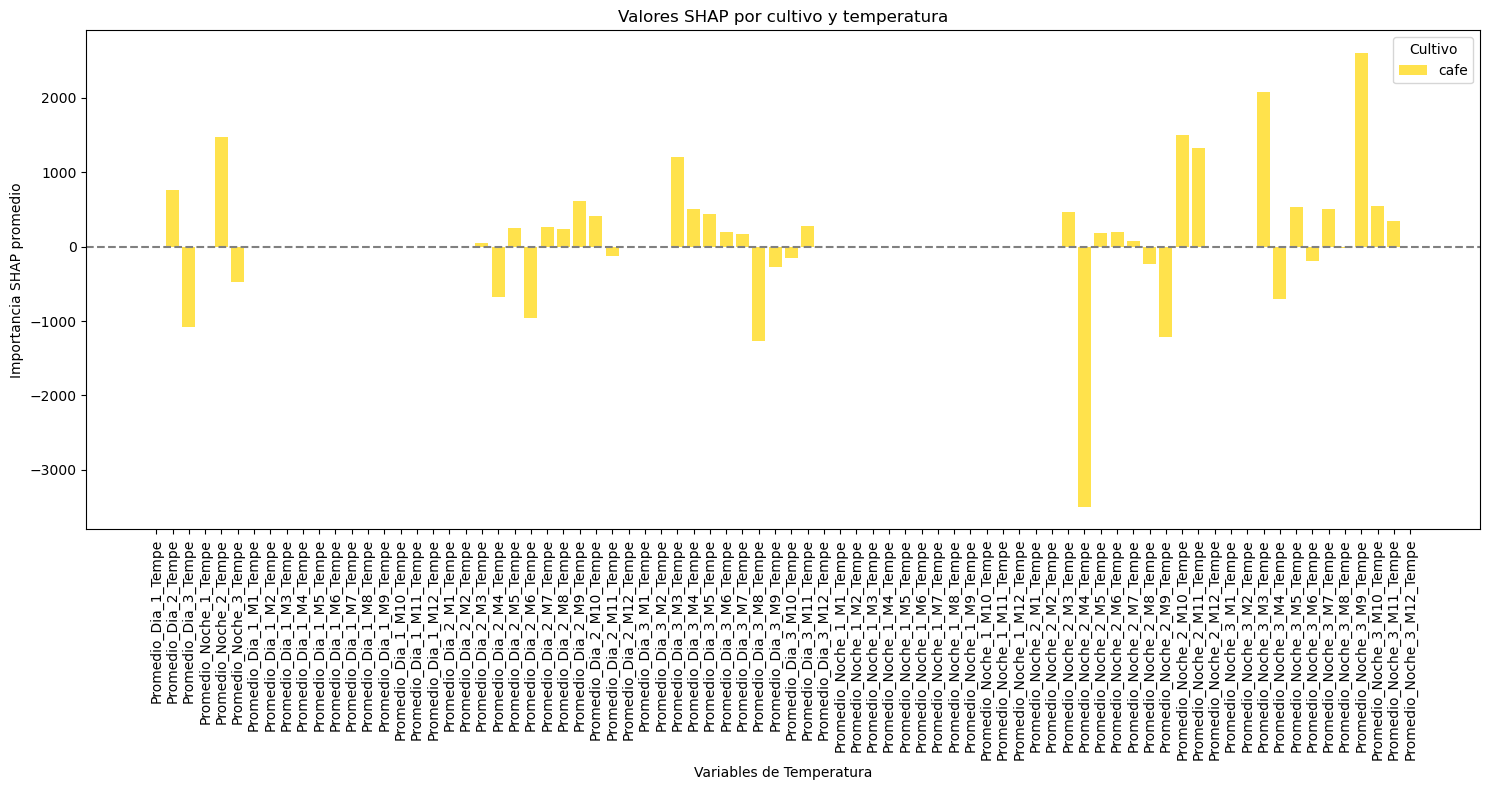

In [33]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV cargado
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['cafe']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un contenedor para los valores SHAP por cultivo
all_shap_values = []
all_temperatures = []

for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]

    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar el modelo usando XGBoost
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Calcular los valores SHAP
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Convertir los valores SHAP a DataFrame y agregar la columna Crop
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df['Crop'] = crop  # Agregar el cultivo actual
    all_shap_values.append(shap_df)
    all_temperatures.extend(X.columns)

# Concatenar todos los valores SHAP
shap_values_df = pd.concat(all_shap_values, ignore_index=True)

# Calcular la media de los valores SHAP para cada variable por cultivo
shap_summary = shap_values_df.groupby('Crop').mean().drop(columns=['Crop'], errors='ignore').T.reset_index()
shap_summary.columns = ['Temperature'] + selected_crops

# Generar la gráfica de barras
plt.figure(figsize=(15, 8))
for crop in selected_crops:
    crop_data = shap_summary[['Temperature', crop]]
    plt.bar(
        crop_data['Temperature'],
        crop_data[crop],
        label=crop,
        color="#FFD700",
        alpha=0.7
    )

# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--')

# Configurar etiquetas y título
plt.xlabel('Variables de Temperatura')
plt.ylabel('Importancia SHAP promedio')
plt.title('Valores SHAP por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()

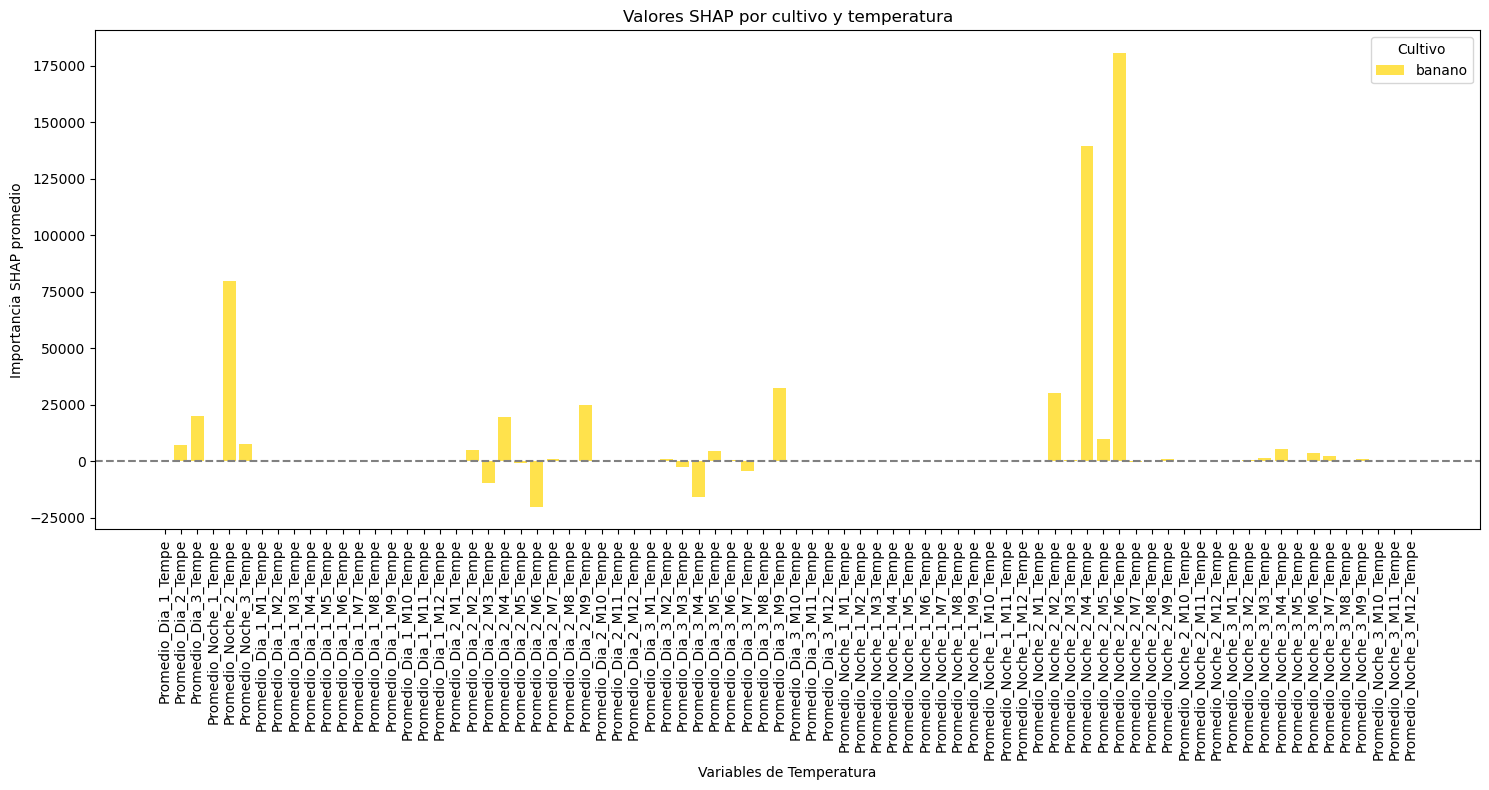

In [34]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV cargado
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['banano']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un contenedor para los valores SHAP por cultivo
all_shap_values = []
all_temperatures = []

for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]

    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar el modelo usando XGBoost
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Calcular los valores SHAP
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Convertir los valores SHAP a DataFrame y agregar la columna Crop
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df['Crop'] = crop  # Agregar el cultivo actual
    all_shap_values.append(shap_df)
    all_temperatures.extend(X.columns)

# Concatenar todos los valores SHAP
shap_values_df = pd.concat(all_shap_values, ignore_index=True)

# Calcular la media de los valores SHAP para cada variable por cultivo
shap_summary = shap_values_df.groupby('Crop').mean().drop(columns=['Crop'], errors='ignore').T.reset_index()
shap_summary.columns = ['Temperature'] + selected_crops

# Generar la gráfica de barras
plt.figure(figsize=(15, 8))
for crop in selected_crops:
    crop_data = shap_summary[['Temperature', crop]]
    plt.bar(
        crop_data['Temperature'],
        crop_data[crop],
        label=crop,
        color="#FFD700",
        alpha=0.7
    )

# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--')

# Configurar etiquetas y título
plt.xlabel('Variables de Temperatura')
plt.ylabel('Importancia SHAP promedio')
plt.title('Valores SHAP por cultivo y temperatura')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()

### PDP

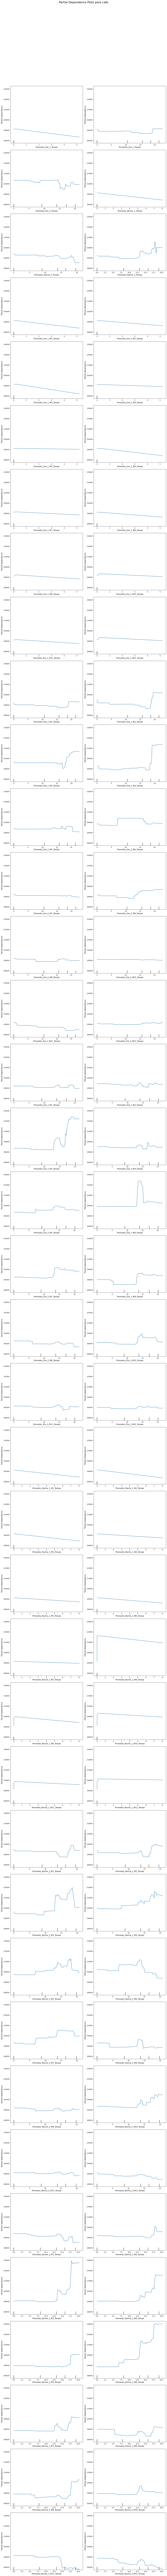

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['cafe']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un modelo de ejemplo y generar PDP para cada cultivo
for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]
    
    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar un modelo de regresión
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Generar los PDP para las variables seleccionadas
    n_features = len(temperature_columns)
    fig, ax = plt.subplots(
        nrows=(n_features // 2) + (n_features % 2), ncols=2, 
        figsize=(15, n_features * 3)  # Ajustar el tamaño en función del número de variables
    )
    ax = ax.flatten()  # Asegurar que los ejes sean unidimensionales
    
    display = PartialDependenceDisplay.from_estimator(
        model, X_train, temperature_columns, ax=ax
    )
    
    # Ajustes estéticos
    for axis in ax:
        axis.set_xlabel(axis.get_xlabel(), fontsize=12)
        axis.set_ylabel(axis.get_ylabel(), fontsize=12)
        axis.tick_params(axis='both', which='major', labelsize=10)
    
    plt.suptitle(f'Partial Dependence Plots para {crop}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reservar espacio para el título
    plt.show()


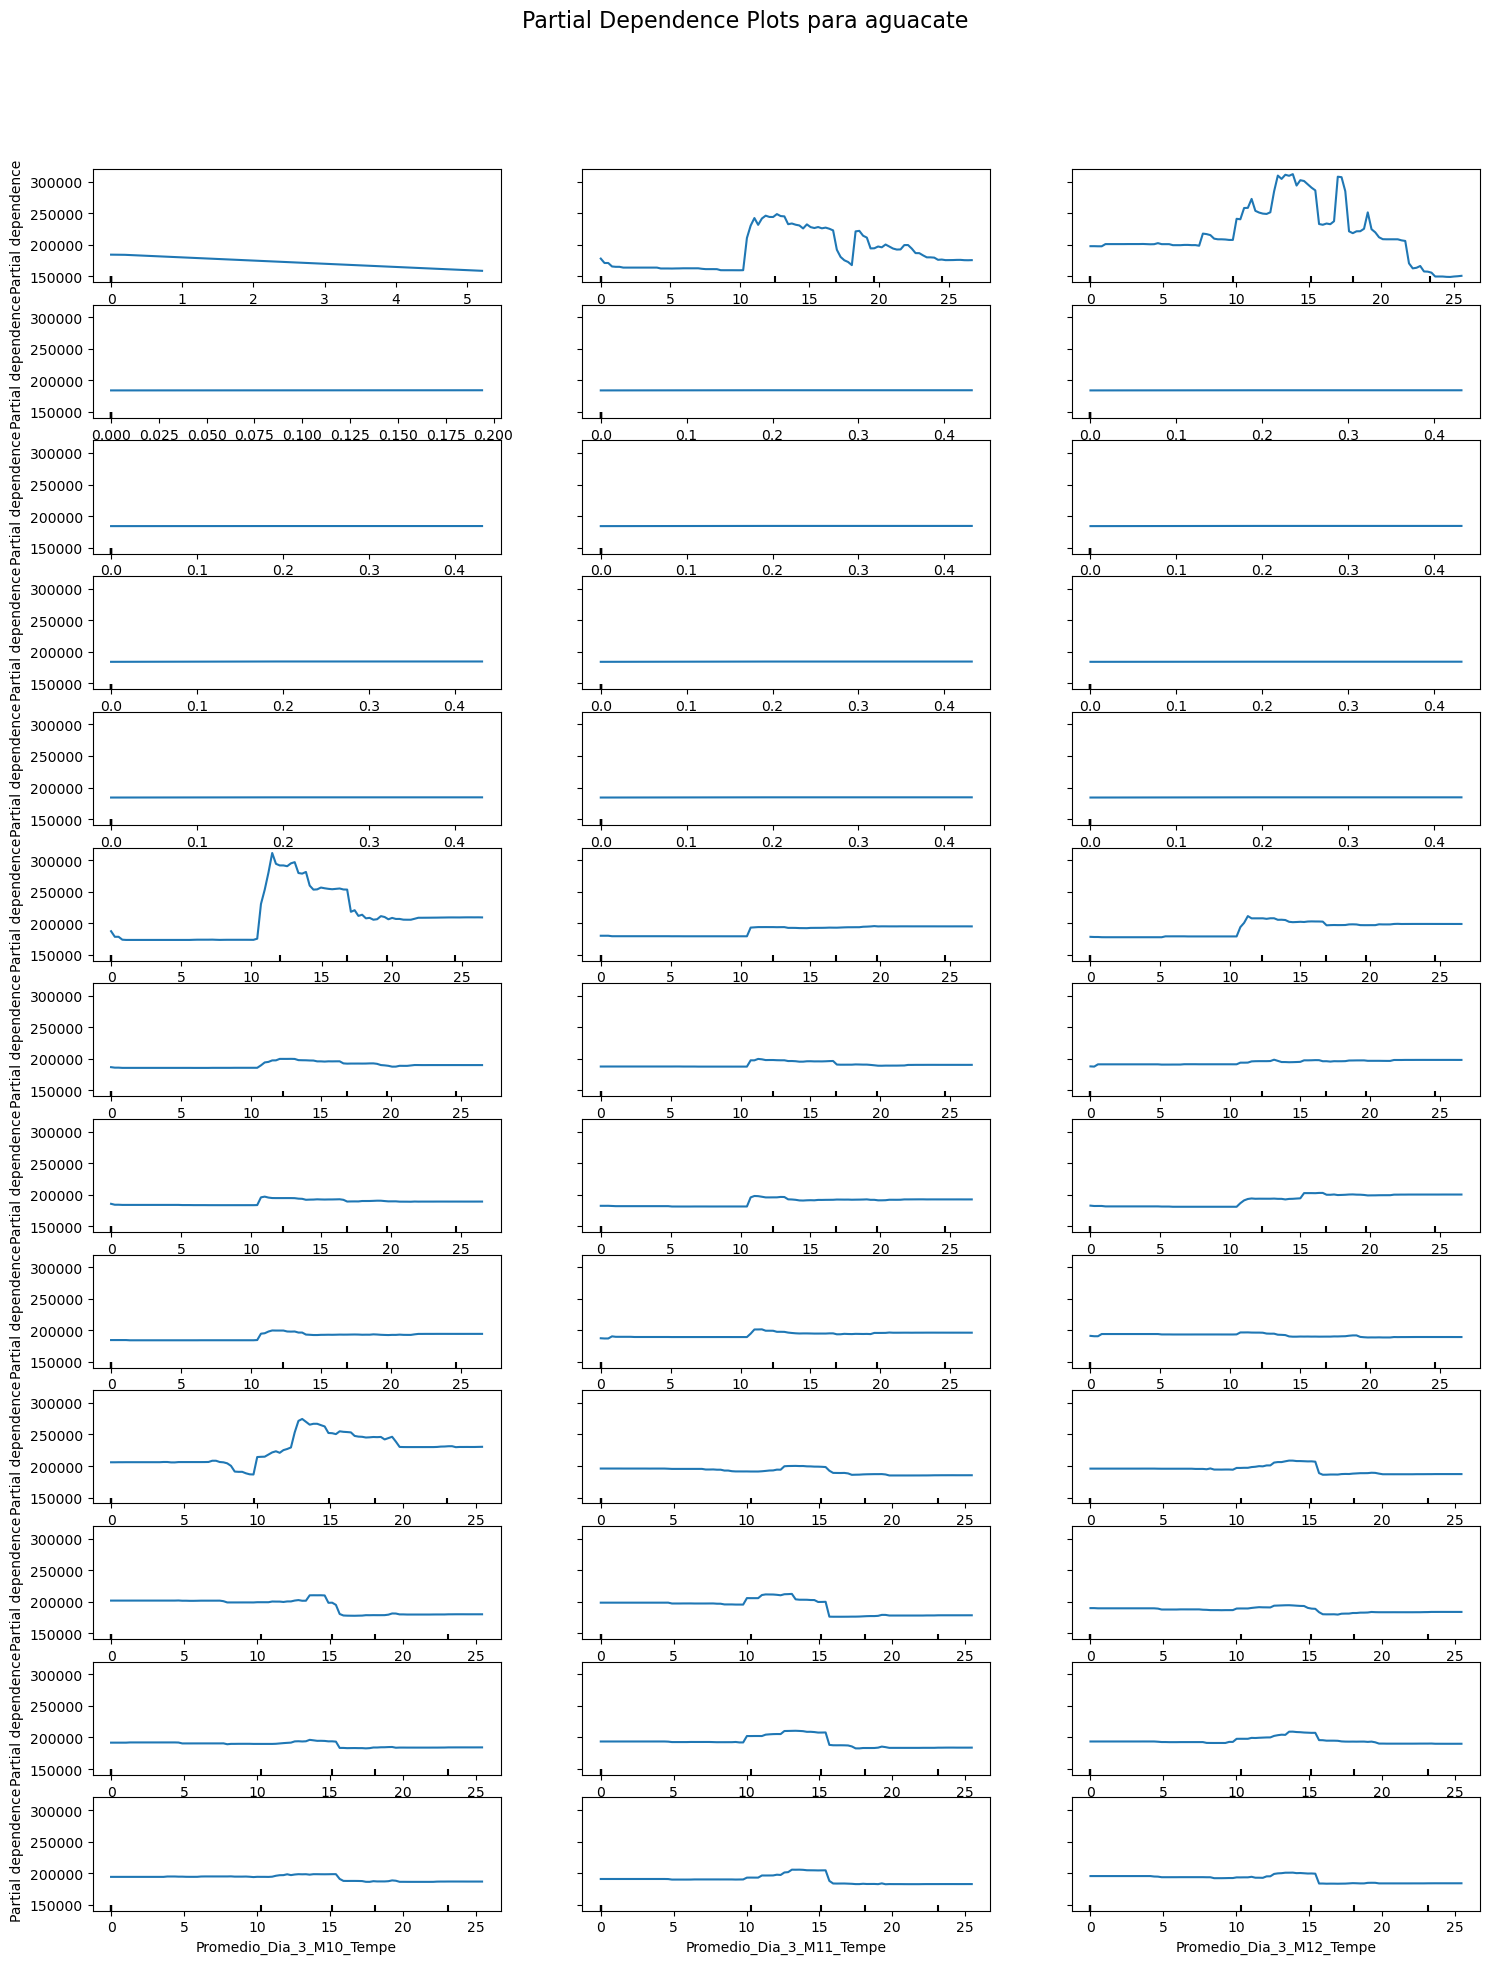

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo Parquet
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['aguacate']  # Puedes añadir más cultivos si lo deseas
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un modelo de ejemplo y generar PDP para cada cultivo
for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]
    
    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio_Dia')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar un modelo de regresión
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Generar los PDP para las variables seleccionadas
    fig, ax = plt.subplots(figsize=(15, 20))  # estaba en 10, ahora en 20
    PartialDependenceDisplay.from_estimator(
        model, X_train, temperature_columns, ax=ax
    )
    
    # Añadir título y ajustar el diseño
    plt.suptitle(f'Partial Dependence Plots para {crop}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para el título
    plt.subplots_adjust(top=0.9)  # Dejar espacio adicional arriba
    plt.show()


### TODOS LOS PRODUCTOS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV
data  = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Obtener los cultivos únicos en los datos
unique_crops = data['cultivo'].str.lower().unique()

# Crear PDP para cada cultivo
for crop in unique_crops:
    # Filtrar datos para el cultivo actual
    crop_data = data[data['cultivo'].str.lower() == crop]
    
    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio_Dia')
    ]
    if not temperature_columns:
        print(f"No se encontraron columnas de temperatura para el cultivo {crop}.")
        continue

    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']
    
    # Verificar si hay suficientes datos para entrenar el modelo
    if len(X) < 10:
        print(f"Datos insuficientes para el cultivo {crop}. Se omite el PDP.")
        continue
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar un modelo de regresión
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Generar los PDP para las variables seleccionadas
    fig, ax = plt.subplots(figsize=(15, 10))
    PartialDependenceDisplay.from_estimator(
        model, X_train, temperature_columns, ax=ax
    )
    plt.suptitle(f'Partial Dependence Plots para {crop}', fontsize=16)
    plt.tight_layout()
    plt.show()


##### FIN TODOS LOS PRODUCTOS.

## XGboost para 4 Mas relevantes por subregion

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['aguacate']
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')
data = data[data['Año'] != 2013]
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Seleccionar las variables de temperatura
temperature_columns = [
    col for col in filtered_data.columns if 'Tempe' in col and col.startswith('Promedio')
]

# Crear un diccionario para almacenar las características más importantes por subregión
top_features_by_subregion = {}

# Iterar por cada subregión para identificar las características más importantes
subregions = filtered_data['SUBREGION'].unique()
for subregion in subregions:
    subregion_data = filtered_data[filtered_data['SUBREGION'] == subregion]

    # Seleccionar las variables de entrada y la variable objetivo
    X = subregion_data[temperature_columns]
    y = subregion_data['Total_producci_n_t']

    # Manejar valores faltantes
    X = X.fillna(0)
    y = y.fillna(0)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar un modelo de regresión con XGBoost
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Calcular importancia de características
    importance = model.feature_importances_

    # Crear un DataFrame para visualizar las importancias
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Guardar las 4 características más importantes para esta subregión
    top_features_by_subregion[subregion] = importance_df.head(4)

# Combinar todas las subregiones en un único DataFrame
combined_top_features = pd.concat(
    {k: v for k, v in top_features_by_subregion.items()}, names=['Subregion']
).reset_index(level=1, drop=True).reset_index()

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['aguacate']
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')
data = data[data['Año'] != 2013]
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Seleccionar las variables de temperatura
temperature_columns = [
    col for col in filtered_data.columns if 'Tempe' in col and col.startswith('Promedio')
]

# Crear un diccionario para almacenar las características más importantes por subregión
top_features_by_subregion = {}

# Iterar por cada subregión para identificar las características más importantes
subregions = filtered_data['SUBREGION'].unique()
for subregion in subregions:
    subregion_data = filtered_data[filtered_data['SUBREGION'] == subregion]

    # Seleccionar las variables de entrada y la variable objetivo
    X = subregion_data[temperature_columns]
    y = subregion_data['Total_producci_n_t']

    # Manejar valores faltantes
    X = X.fillna(0)
    y = y.fillna(0)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar un modelo de regresión con XGBoost
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Calcular importancia de características
    importance = model.feature_importances_

    # Crear un DataFrame para visualizar las importancias
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Guardar las 4 características más importantes para esta subregión
    top_features_by_subregion[subregion] = importance_df.head(4)

    # Generar gráficos PDP para las 4 características principales
    top_features = importance_df.head(4)['Feature'].tolist()
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    ax = ax.flatten()
    for i, feature in enumerate(top_features):
        PartialDependenceDisplay.from_estimator(model, X_train, [feature], ax=ax[i])
        ax[i].set_title(f"PDP for {feature} - Subregion {subregion}", fontsize=12)

    plt.tight_layout()
    plt.savefig(f'PDP_Subregion_{subregion}.png')
    plt.close()

# Combinar todas las subregiones en un único DataFrame
combined_top_features = pd.concat(
    {k: v for k, v in top_features_by_subregion.items()}, names=['Subregion']
).reset_index(level=1, drop=True).reset_index()

# Guardar los resultados en un archivo CSV
combined_top_features.to_csv('Top_Features_By_Subregion.csv', index=False)

print("Las características más relevantes por subregión han sido guardadas en 'Top_Features_By_Subregion.csv'.")
print("Los gráficos PDP se han guardado como archivos PNG por subregión.")


c:\Users\JohanStivenPaezBermu\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\JohanStivenPaezBermu\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\JohanStivenPaezBermu\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\JohanStivenPaezBermu\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expan

Las características más relevantes por subregión han sido guardadas en 'Top_Features_By_Subregion.csv'.
Los gráficos PDP se han guardado como archivos PNG por subregión.


### Sepacion

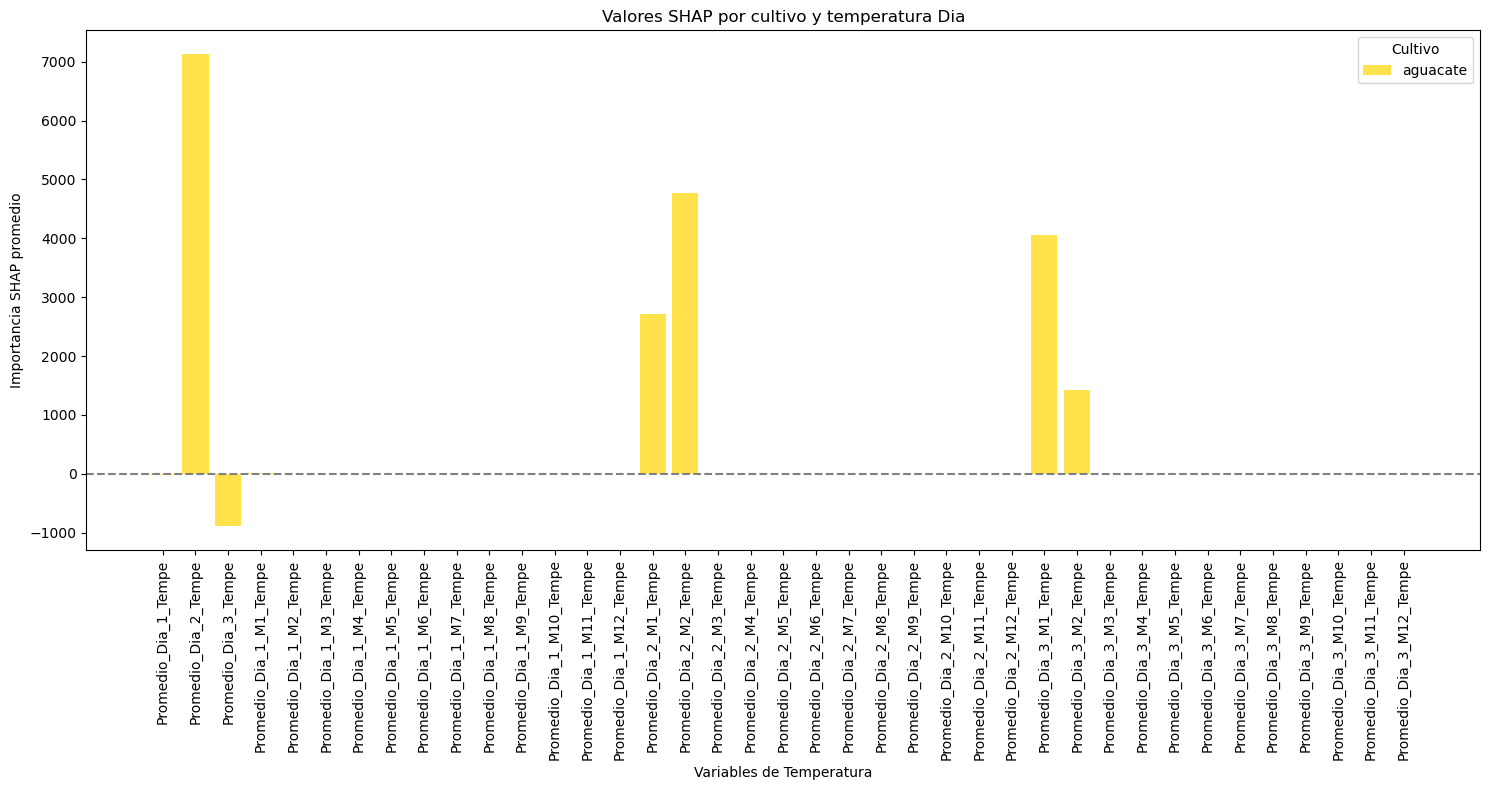

In [10]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV cargado
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['aguacate']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un contenedor para los valores SHAP por cultivo
all_shap_values = []
all_temperatures = []

for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]

    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio_Dia')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar el modelo usando XGBoost
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Calcular los valores SHAP
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Convertir los valores SHAP a DataFrame y agregar la columna Crop
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df['Crop'] = crop  # Agregar el cultivo actual
    all_shap_values.append(shap_df)
    all_temperatures.extend(X.columns)

# Concatenar todos los valores SHAP
shap_values_df = pd.concat(all_shap_values, ignore_index=True)

# Calcular la media de los valores SHAP para cada variable por cultivo
shap_summary = shap_values_df.groupby('Crop').mean().drop(columns=['Crop'], errors='ignore').T.reset_index()
shap_summary.columns = ['Temperature'] + selected_crops

# Generar la gráfica de barras
plt.figure(figsize=(15, 8))
for crop in selected_crops:
    crop_data = shap_summary[['Temperature', crop]]
    plt.bar(
        crop_data['Temperature'],
        crop_data[crop],
        label=crop,
        color="#FFD700",
        alpha=0.7
    )

# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--')

# Configurar etiquetas y título
plt.xlabel('Variables de Temperatura')
plt.ylabel('Importancia SHAP promedio')
plt.title('Valores SHAP por cultivo y temperatura Dia')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()

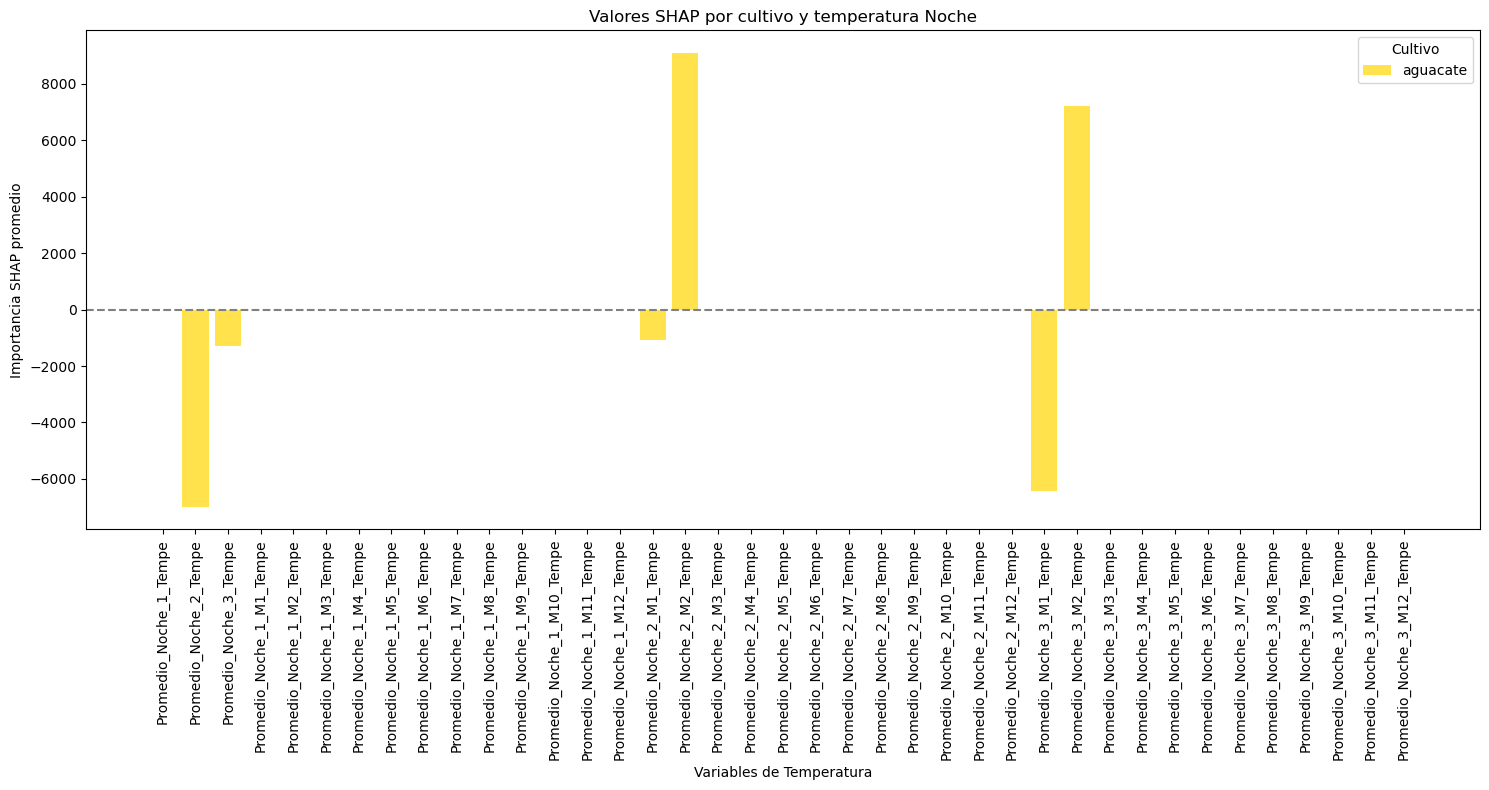

In [9]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo CSV cargado
data = pd.read_parquet('C:\\Users\\JohanStivenPaezBermu\\OneDrive - Asulado\\Python\\Python_MSc\\Tesis\\Desarrollo_Tesis\\DF_Definitivos\\Datos_Nueva_Version_Dic_06.parquet')

# Excluir registros con Año igual a 2013
data = data[data['Año'] != 2013]

# Filtrar datos de entrenamiento (2014-2020) y validación (2021 en adelante)
train_data = data[(data['Año'] >= 2014) & (data['Año'] <= 2020)]
test_data = data[data['Año'] >= 2021]

# Filtrar los datos para incluir solo los cultivos de interés
selected_crops = ['aguacate']
filtered_data = data[data['cultivo'].str.lower().isin(selected_crops)]

# Crear un contenedor para los valores SHAP por cultivo
all_shap_values = []
all_temperatures = []

for crop in selected_crops:
    # Filtrar datos para el cultivo actual
    crop_data = filtered_data[filtered_data['cultivo'].str.lower() == crop]

    # Seleccionar las variables de temperatura y la variable objetivo
    temperature_columns = [
        col for col in crop_data.columns if 'Tempe' in col and col.startswith('Promedio_Noche')
    ]
    X = crop_data[temperature_columns]
    y = crop_data['Total_producci_n_t']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar el modelo usando XGBoost
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Calcular los valores SHAP
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Convertir los valores SHAP a DataFrame y agregar la columna Crop
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df['Crop'] = crop  # Agregar el cultivo actual
    all_shap_values.append(shap_df)
    all_temperatures.extend(X.columns)

# Concatenar todos los valores SHAP
shap_values_df = pd.concat(all_shap_values, ignore_index=True)

# Calcular la media de los valores SHAP para cada variable por cultivo
shap_summary = shap_values_df.groupby('Crop').mean().drop(columns=['Crop'], errors='ignore').T.reset_index()
shap_summary.columns = ['Temperature'] + selected_crops

# Generar la gráfica de barras
plt.figure(figsize=(15, 8))
for crop in selected_crops:
    crop_data = shap_summary[['Temperature', crop]]
    plt.bar(
        crop_data['Temperature'],
        crop_data[crop],
        label=crop,
        color="#FFD700",
        alpha=0.7
    )

# Añadir una línea negra en el eje X cuando el valor es cero
plt.axhline(0, color='gray', linewidth=1.5, linestyle='--')

# Configurar etiquetas y título
plt.xlabel('Variables de Temperatura')
plt.ylabel('Importancia SHAP promedio')
plt.title('Valores SHAP por cultivo y temperatura Noche')
plt.xticks(rotation=90)
plt.legend(title='Cultivo')
plt.tight_layout()
plt.show()